# IDEA: We may NOT need much datapoints for training a QCNN

In [1]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
from pennylane import numpy as np

from PhaseEstimation import vqe, annni_model, qcnn, visualization, general, losses
from PhaseEstimation import visualization as qplt
from PhaseEstimation import general as qmlgen

import joblib, os
from matplotlib import pyplot as plt


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

In [2]:
def low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 45, plot = True, gaussian = True):
    if plot and gaussian:
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        mu = int(np.sqrt(vqeclass.n_states))//2
        x = np.arange(mu-3*sigma,mu+3*sigma)
        plt.plot(x, gaussian(x, mu, sigma) )
        plt.axvline(x=0, ls = '--', color='red')
        plt.axvline(x=2*mu, ls = '--', color='red')
        plt.title('Drawing distribution')
        plt.show()
                 
    mean_acc = []
    std_acc  = []

    for S_size in S_sizes:
        accs = []

        for _ in range(n_qcnns):
            if gaussian:
                train_index = qcnn.get_trainset_gaussian(vqeclass, S_size, sigma = sigma)
            else:
                train_index_x = np.random.choice(np.arange(side), size=S_size//2, replace = False)
                train_index_y = np.random.choice(np.arange(side, 2*side-1), size=S_size//2, replace = False)
                
                train_index = np.concatenate((train_index_x, train_index_y))
                                                 
            qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
            qcnnclass.train(lr, epochs, train_index, losses.cross_entropy)

            accs.append(qcnn.ANNNI_accuracy(qcnnclass, plot = False) )

        mean_acc.append(np.mean(accs))
        std_acc.append(np.std(accs))

    s_str = ''
    for s_size in S_sizes:
        s_str += str(s_size) + '_'

    path      = '../data/'
    folder    = 'N'+str(N)+'n'+str(side)+'sizes'+s_str[:-1]
    subfolder = 'gaussian' if gaussian else 'uniform'

    if folder not in os.listdir(path):
        os.makedirs(path+folder)
    if subfolder not in os.listdir(path+folder):
        os.makedirs(path+folder+'/'+subfolder)
        
    joblib.dump(mean_acc, path+folder+'/'+subfolder+'/mean_acc')
    joblib.dump(std_acc,  path+folder+'/'+subfolder+'/std_acc' )
    
    if plot:
        x = np.arange(len(mean_acc))
        plt.plot(x, mean_acc, color ='red', alpha=.3)
        plt.errorbar(x, mean_acc, yerr = 3*np.array(std_acc),fmt='o', color = 'red', ecolor='red')
        plt.xticks(x, labels = S_sizes)
        plt.xlabel('Training points')
        plt.ylim(None,1.2)
        plt.grid(True)

    
    return mean_acc, std_acc

def low_points_equidistant(vqeclass, n_points_side, lr, epochs, label ='a'):
    side = int(np.sqrt(vqeclass.n_states))
    points = np.linspace(0,side-1,n_points_side).astype(int)
    if n_points_side%2 != 0:
        points = np.delete(points, n_points_side//2)

    points = np.concatenate((points, points[1:] + side))

    idxs = []
    for point in points:
        idxs.append(qmlgen.simple_to_idx(point, side) )
    idxs = np.array(idxs)

    qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
    qcnnclass.train(lr, epochs, points, losses.cross_entropy)

    qplt.show_QCNN_classificationANNNI(qcnnclass, train_index = idxs, hard_thr = False, label = label, info=True)

    #qcnn.ANNNI_accuracy(qcnnclass, plot = True)

    return qcnnclass
    
def plot_lowpoints(N, side, S_sizes):
    path      = '../data/'
    s_str = ''
    for size in S_sizes:
        s_str += str(size)+'_'
    folder    = 'N'+str(N)+'n'+str(side)+'sizes'+s_str[:-1]
    
    print(path+folder)
    if folder in os.listdir(path):
        if 'gaussian' in os.listdir(path+folder):
            mean_acc_gauss = joblib.load(path+folder+'/gaussian/mean_acc')
            std_acc_gauss = joblib.load(path+folder+'/gaussian/std_acc')
            x = np.arange(len(mean_acc_gauss))
            plt.plot(x, mean_acc_gauss, color ='red', alpha=.3)
            plt.errorbar(x, mean_acc_gauss, yerr = 3*np.array(std_acc_gauss),fmt='o', color = 'red', ecolor='red', capsize = 3, label = 'Gaussian')
        if 'uniform' in os.listdir(path+folder):
            mean_acc_uni = joblib.load(path+folder+'/uniform/mean_acc')
            std_acc_uni = joblib.load(path+folder+'/uniform/std_acc')
            x = np.arange(len(mean_acc_uni))
            plt.plot(x, mean_acc_uni, color ='blue', alpha=.3)
            plt.errorbar(x, mean_acc_uni, yerr = 3*np.array(std_acc_uni), fmt='o', color = 'blue', ecolor='blue', alpha =.6, capsize=3, label = 'Uniform')
            
        plt.xticks(x, labels = S_sizes)
        plt.xlabel('Training points')
        plt.ylim(None,1.2)
        plt.grid(True)
        plt.legend()

In [9]:
# Load all possible VQEs to compute the transition phase line
N    = 12
side = 100

lr = .25
epochs  = 1000
S_sizes = np.concatenate((np.arange(1,5), np.arange(0,51,5)[1:]))*2

n_qcnns  = 10

In [10]:
path = '../data/vqes/ANNNI/'
filename = 'N'+str(N)+'n'+str(side)

In [11]:
vqeclass = vqe.load_vqe(path+filename)

Cost: 0.002214164240285754: 100%|██████████| 5000/5000 [02:35<00:00, 32.18it/s] 


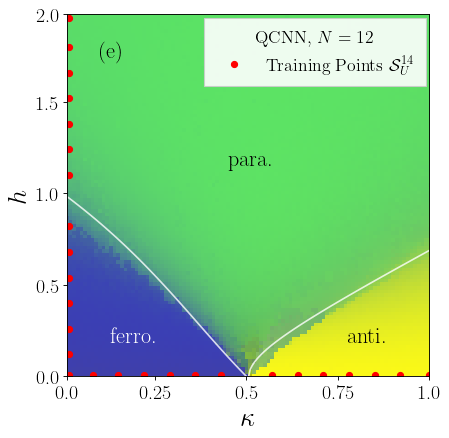

In [14]:
myqcnn = low_points_equidistant(vqeclass, 15, 2.5, 5000, label='e')
plt.savefig('../data/12classification.svg')

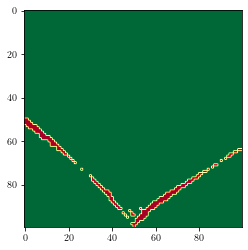

tensor(0.9792, requires_grad=True)

In [13]:
qcnn.ANNNI_accuracy(myqcnn, plot = True)

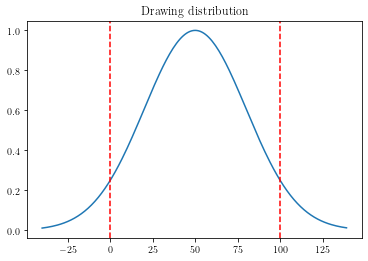

Cost: 0.059540100395679474: 100%|███████████| 1000/1000 [04:57<00:00,  3.36it/s]


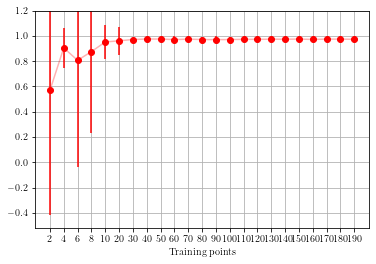

In [19]:
_ = low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 30, gaussian = True)

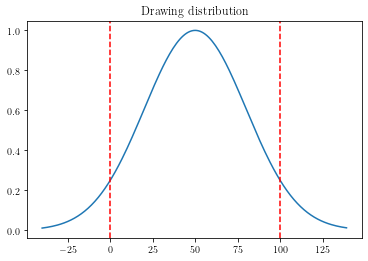

Cost: 0.018367476761341095: 100%|██████████| 1000/1000 [00:17<00:00, 56.24it/s] 


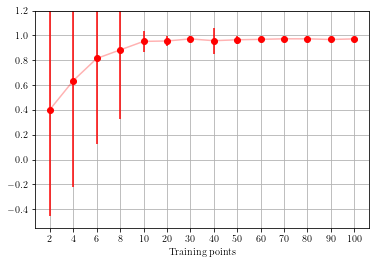

In [84]:
_ = low_points_random(vqeclass, lr, epochs, n_qcnns, S_sizes, sigma = 30, gaussian = True)

In [325]:
def compare_one(N, side, S_size, limit = 200, marker ='o', label ='a'):
    path      = '../data/'
    s_str = ''
    for size in S_size:
        s_str += str(size)+'_'
    folder = 'N'+str(N)+'n'+str(side)+'sizes'+s_str[:-1]

    path_uni = path+folder+'/'+'uniform'
    path_gau = path+folder+'/'+'gaussian'

    l = len(S_size) if (limit > np.max(S_size)) else int(np.where(S_size == limit)[0])+1
    x = np.arange(l)

    mean1, mean2 = joblib.load(path_uni+'/mean_acc')[:l], joblib.load(path_gau+'/mean_acc')[:l]
    std1,  std2  = joblib.load(path_uni+'/std_acc')[:l],  joblib.load(path_gau+'/std_acc')[:l]
    
    plt.figure(figsize=(6, 6))
    plt.plot(x, mean1, color ='red', alpha=.3)
    plt.errorbar(x, mean1, yerr = np.array(std1),fmt=marker, color = 'red', ecolor='red', capsize = 3, label = r'$\mathcal{S}_U^n$ (Uniform)')
    plt.plot(x, mean2, color ='blue', alpha=.3)
    plt.errorbar(x, mean2, yerr = np.array(std2),fmt=marker, color = 'blue', ecolor='blue', capsize = 3, label = r'$\mathcal{S}_G^n$ (Gaussian)')

    plt.xticks(x, labels = S_size[:l]//2, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(r'Training Points $n$', fontsize=20)
    plt.ylim(None,1.1)
    plt.axhline(1, ls = '--', color = 'black', alpha = .8)
    plt.ylabel('Accuracy', fontsize=20)
    plt.text(8,.7, '('+label+')', fontsize=20)
    leg = plt.legend(fontsize=20)
    leg.set_title(r'$N={}$'.format(N),prop={'size':24})

def compare_two(N1, N2, side, S_size1, S_size2, uniform = True, limit = 200, marker ='o'):
    path      = '../data/'
    s_str1 = ''
    for size in S_size1:
        s_str1 += str(size)+'_'
    folder1 = 'N'+str(N1)+'n'+str(side)+'sizes'+s_str1[:-1]
    s_str2 = ''
    for size in S_size2:
        s_str2 += str(size)+'_'
    folder2 = 'N'+str(N2)+'n'+str(side)+'sizes'+s_str2[:-1]
    subfolder = 'uniform' if uniform else 'gaussian'

    path1 = path+folder1+'/'+subfolder
    path2 = path+folder2+'/'+subfolder

    l1, l2 = len(S_size1), len(S_size2)
    if limit > np.max(np.concatenate((S_size1, S_size2)) ):
        x1 = np.arange(l1)
        x2 = np.arange(l2)
        x  = np.arange(max(l1,l2))
    else:
        l1 = int(np.where(S_size1 == limit)[0])+1
        l2 = int(np.where(S_size2 == limit)[0])+1
        if l1 != l2:
            raise ValueError('Invalid arrays')
        x = x1 = x2 = np.arange(l1)

    mean1, mean2 = joblib.load(path1+'/mean_acc')[:l1], joblib.load(path2+'/mean_acc')[:l2]
    std1,  std2  = joblib.load(path1+'/std_acc')[:l1],  joblib.load(path2+'/std_acc')[:l2]
    
    plt.figure(figsize=(6.4, 6.4))
    plt.plot(x1, mean1, color ='red', alpha=.3)
    plt.errorbar(x1, mean1, yerr = np.array(std1),fmt=marker, color = 'red', ecolor='red', capsize = 3, label = r'N = {}'.format(str(N1)))
    plt.plot(x2, mean2, color ='blue', alpha=.3)
    plt.errorbar(x2, mean2, yerr = np.array(std2),fmt=marker, color = 'blue', ecolor='blue', capsize = 3, label = r'N = {}'.format(str(N2)))

    plt.xticks(x, labels = np.intersect1d(S_size1,S_size2)[:l1]//2, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(r'Training Points $n$', fontsize=20)
    plt.ylim(None,1.1)
    plt.axhline(1, ls = '--', color = 'black', alpha = .8)
    plt.ylabel('Accuracy', fontsize=20)
    plt.legend(fontsize=16)

def compare_two_sidebyside(N1, N2, side, S_size1, S_size2, limit = 50, marker ='o'):
    path      = '../data/'
    s_str1 = ''
    for size in S_size1:
        s_str1 += str(size)+'_'
    folder1 = 'N'+str(N1)+'n'+str(side)+'sizes'+s_str1[:-1]
    s_str2 = ''
    for size in S_size2:
        s_str2 += str(size)+'_'
    folder2 = 'N'+str(N2)+'n'+str(side)+'sizes'+s_str2[:-1]

    path1_uni, path1_gau = path+folder1+'/uniform', path+folder1+'/gaussian'
    path2_uni, path2_gau = path+folder2+'/uniform', path+folder2+'/gaussian'

    l1 = int(np.where(S_size1 == limit)[0])+1
    l2 = int(np.where(S_size2 == limit)[0])+1
    if l1 != l2:
        raise ValueError('Invalid arrays')
    x = x1 = x2 = np.arange(l1)

    mean1_uni, mean2_uni = joblib.load(path1_uni+'/mean_acc')[:l1], joblib.load(path2_uni+'/mean_acc')[:l2]
    mean1_gau, mean2_gau = joblib.load(path1_gau+'/mean_acc')[:l1], joblib.load(path2_gau+'/mean_acc')[:l2]
    std1_uni,  std2_uni  = joblib.load(path1_uni+'/std_acc')[:l1],  joblib.load(path2_uni+'/std_acc')[:l2]
    std1_gau,  std2_gau  = joblib.load(path1_gau+'/std_acc')[:l1],  joblib.load(path2_gau+'/std_acc')[:l2]

    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    
    axs[0].plot(x1, mean1_uni, color ='red', alpha=.3)
    axs[0].errorbar(x1, mean1_uni, yerr = np.array(std1_uni),fmt=marker, color = 'red', ecolor='red', capsize = 3, label = 'uniform')
    axs[0].plot(x1, mean1_gau, color ='blue', alpha=.3)
    axs[0].errorbar(x1, mean1_gau, yerr = np.array(std1_gau),fmt=marker, color = 'blue', ecolor='blue', capsize = 3, label = 'gaussian')

    axs[1].plot(x2, mean2_uni, color ='red', alpha=.3)
    axs[1].errorbar(x2, mean2_uni, yerr = np.array(std2_uni),fmt=marker, color = 'red', ecolor='red', capsize = 3, label = 'uniform')
    axs[1].plot(x2, mean2_gau, color ='blue', alpha=.3)
    axs[1].errorbar(x2, mean2_gau, yerr = np.array(std2_gau),fmt=marker, color = 'blue', ecolor='blue', capsize = 3, label = 'gaussian')

    axs[0].set_title('N = {0}'.format(N1))
    axs[1].set_title('N = {0}'.format(N2))
    axs[0].axhline(1, ls = '--', color = 'black', alpha = .8)
    axs[1].axhline(1, ls = '--', color = 'black', alpha = .8)
    axs[0].set_xlabel(r'Training Points $n$')
    axs[1].set_xlabel(r'Training Points $n$')
    axs[0].set_ylabel('Accuracy')
    #axs[1].set_ylabel('Accuracy')
    axs[0].set_ylim(.1,1.1)
    axs[1].set_ylim( axs[0].get_ylim() ) # align axes
    axs[1].set_yticks([]) # set ticks to be empty (no ticks, no tick-labels)
    axs[0].legend()
    axs[1].legend()
    axs[0].set_xticks(x, labels = np.intersect1d(S_size1,S_size2)[:l1])
    axs[1].set_xticks(x, labels = np.intersect1d(S_size1,S_size2)[:l1])
    fig.subplots_adjust(wspace= 0.05)


In [326]:
S_sizes1 = np.concatenate((np.arange(1,5), np.arange(0,51,5)[1:]))*2
S_sizes2 = np.concatenate((np.arange(1,5), np.arange(0,100,5)[1:]))*2

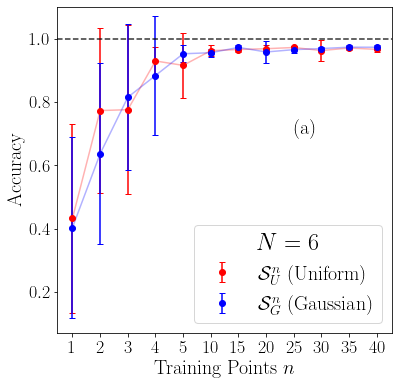

In [327]:
compare_one(6,100,S_sizes1,limit = 80)
plt.savefig('../data/accuracies/6.svg')

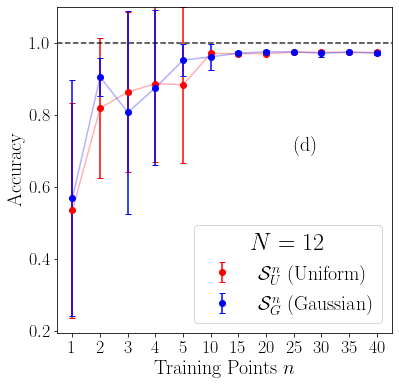

In [329]:
compare_one(12,100,S_sizes2,limit = 80, label='d')
plt.savefig('../data/accuracies/12.svg')

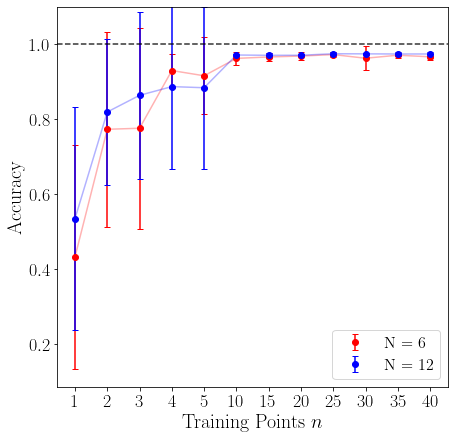

In [273]:
compare_two(6,12,100,S_sizes1, S_sizes2, limit = 80)
#plt.show()

In [13]:
del(vqeclass)

In [14]:
myvqe = vqe.load_vqe('../data/vqes/ANNNI/N'+str(N)+'n'+str(side))

# Train VQE recycling parameters 
#myvqe.train(0.3, 250, recycle = True, epochs_batch_size = 250, batch_size = 1)
#myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.2,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))
myvqe.train_refine(.1,  1000, 0.002, assist = True)
myvqe.save('./N'+str(N)+'n'+str(side))

  0%|                                                   | 0/100 [10:12<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]